# PINN

In [2]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs  # Latin Hypercube Sampling
from torch.autograd import grad
torch.manual_seed(2000)
np.random.seed(2000)
import time
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Exact solution for the Poisson equation
def exact_solution(x, t, c=2):
    return torch.sin(np.pi * x) * torch.cos(c * np.pi * t) + 0.5 * torch.sin(2 * c * np.pi * x) * torch.cos(4 * c * np.pi * t)

# Generate training data
def get_data(lb, ub, Nx, Nt, Nu, Nf):
    x = torch.linspace(lb[0], ub[0], Nx)
    t = torch.linspace(lb[1], ub[1], Nt)
    x, t = torch.meshgrid(x, t, indexing="ij")

    # Initial condition u(0, x) = sin(πx) + 0.5sin(4πx)
    u_ic = torch.sin(np.pi * x[:, 0]) + 0.5 * torch.sin(4 * np.pi * x[:, 0])  # t=0

    # Boundary conditions
    u_bc_left = torch.zeros_like(t[0, :])  # x=0
    u_bc_right = torch.zeros_like(t[-1, :])  # x=1

    # Concatenate boundary/initial conditions
    X_u = torch.cat([ 
        torch.stack([x[:, 0], t[:, 0]], dim=1),  # Initial condition
        torch.stack([x[0, :], t[0, :]], dim=1),  # Boundary x=0
        torch.stack([x[-1, :], t[-1, :]], dim=1)  # Boundary x=1
    ], dim=0)

    u_u = torch.cat([u_ic, u_bc_left, u_bc_right], dim=0).reshape(-1, 1)
    X_u = torch.cat([X_u, u_u], dim=1)

    # Randomly sample Nu points from X_u
    idx = np.random.choice(X_u.shape[0], size=Nu, replace=False)
    X_u_sampled = X_u[idx, :]

    # Latin hypercube sampling for X_f (collocation points)
    X_f = lb + (ub - lb) * torch.tensor(lhs(2, samples=Nf), dtype=torch.float32)

    # Combine collocation points and sampled boundary/initial points
    X_train = torch.cat([X_f, X_u_sampled[:, :2]], dim=0)

    return X_train, X_u_sampled

# Physics loss for the Poisson equation
def physics_loss(model, X_f, c=2):
    X_f.requires_grad_(True)
    u = model(X_f)
    u_t = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
    u_tt = grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1:2]
    u_x = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    u_xx = grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]

    # Poisson equation: u_tt - c^2 * u_xx = 0
    f = u_tt - c**2 * u_xx
    return torch.mean(f**2)

# L2 relative error
def l2_relative_error(u_true, u_pred):
    u_true_np = u_true.detach().numpy()
    u_pred_np = u_pred.detach().numpy()
    return np.linalg.norm(u_true_np - u_pred_np) / np.linalg.norm(u_true_np)
def train(model, optimizer, X_train, X_u, epochs, Nf):
    model.train()
   
    # Split the training data
    X_f = X_train[:Nf, :]
    X_u_train = X_u[:, :2]
    u_u_train = X_u[:, 2:]

    # Predict boundary/initial conditions
    u_pred = model(X_u_train)
    loss_u = torch.mean((u_pred - u_u_train)**2)

    # Physics-informed loss
    loss_f = physics_loss(model, X_f)

    # Add initial condition for time derivative
    # Extract x and t from X_u_train, where t = 0 for the initial condition
    x_init = X_u_train[:, 0].reshape(-1, 1)
    t_init = torch.zeros_like(x_init, requires_grad=True)  # Ensure t_init requires gradients
    u_init_pred = model(torch.cat([x_init, t_init], dim=1))  # Predict u at t = 0
    u_t_init_pred = grad(u_init_pred, t_init, grad_outputs=torch.ones_like(u_init_pred), create_graph=True)[0]  # Calculate time derivative u_t
    loss_u_t = torch.mean(u_t_init_pred**2)
    return  loss_u, loss_f, loss_u_t

# Predict function
def predict(model, x, t):
    model.eval()
    X = torch.stack([x.reshape(-1), t.reshape(-1)], dim=1)
    u_pred = model(X)
    return u_pred.reshape(x.shape)

# Main code
if __name__ == "__main__":
    # Parameters
    lb = torch.tensor([0.0, 0.0])  # Lower bounds for x and t
    ub = torch.tensor([1.0, 0.5])  # Upper bounds for x and t
    Nx, Nt = 256, 100  # Discretization for x and t
    Nu, Nf = 300, 500  # Number of boundary/initial and collocation points
    layers = [2, 100, 100,  1]  # Neural network structure
    epochs = 5000  # Number of training epochs
    learning_rate = 0.001

    # Generate training data
    X_train, X_u_sampled = get_data(lb, ub, Nx, Nt, Nu, Nf)
    num_1 = [30000]
    total_steps=30000
    thresholds = [1e-3, 1e-3, 1e-3, 1e-3,1e-3]
    L2_errors = []
    start_time = time.time() 
   # Training loop
    for i in range(len(num_1)):
        # Initialize PINN
        model = PINN(layers)
        weight_history = {name: [] for name, _ in model.named_parameters()}
        loss_spf=[]
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        start_time = time.time() 
        for epoch in range(num_1[i]):
            optimizer.zero_grad()
            #loss, loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
            loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
            loss = 10*loss_u + loss_f + loss_u_t
            loss.backward()
            loss_true=loss_u + loss_f + loss_u_t
            loss_spf.append(loss_true.item())
            optimizer.step()
            for name, param in model.named_parameters():
                weight_history[name].append(param.clone().detach().numpy().flatten())
            if epoch % 1000 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}/{num_1[i]}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")
        
        end_time = time.time()  # 训练结束计时
        elapsed = end_time - start_time
        print(f"⏱  训练总耗时: {elapsed:.2f} 秒")
        # Generate test data
        x = torch.linspace(lb[0], ub[0], Nx)
        t = torch.linspace(lb[1], ub[1], Nt)
        x, t = torch.meshgrid(x, t, indexing="ij")
        u_true = exact_solution(x, t)

        # Predict the solution
        u_pred = predict(model, x, t)

        # Compute L2 relative error
        error = l2_relative_error(u_true, u_pred)
        L2_errors.append(error)
        print(f"L2 Relative Error: {error.item():.6f}")
        
        
print( L2_errors)

Epoch 0/30000, Loss: 3.512451, Loss_u: 0.349196, Loss_f: 0.017782, Loss_u_t: 0.002710
Epoch 1000/30000, Loss: 0.486384, Loss_u: 0.047301, Loss_f: 0.010044, Loss_u_t: 0.003330
Epoch 2000/30000, Loss: 0.258136, Loss_u: 0.022905, Loss_f: 0.022325, Loss_u_t: 0.006758
Epoch 3000/30000, Loss: 0.206950, Loss_u: 0.011360, Loss_f: 0.087828, Loss_u_t: 0.005524
Epoch 4000/30000, Loss: 0.127079, Loss_u: 0.007476, Loss_f: 0.050358, Loss_u_t: 0.001964
Epoch 4999/30000, Loss: 0.073500, Loss_u: 0.005713, Loss_f: 0.015299, Loss_u_t: 0.001068
Epoch 5000/30000, Loss: 0.073611, Loss_u: 0.005706, Loss_f: 0.015552, Loss_u_t: 0.001000
Epoch 6000/30000, Loss: 0.054639, Loss_u: 0.004654, Loss_f: 0.007164, Loss_u_t: 0.000936
Epoch 7000/30000, Loss: 0.163941, Loss_u: 0.004016, Loss_f: 0.119883, Loss_u_t: 0.003897
Epoch 8000/30000, Loss: 0.041155, Loss_u: 0.003399, Loss_f: 0.006410, Loss_u_t: 0.000754
Epoch 9000/30000, Loss: 0.034823, Loss_u: 0.002950, Loss_f: 0.004688, Loss_u_t: 0.000630
Epoch 10000/30000, Loss:

# SPF-PINN-1

In [3]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs  # Latin Hypercube Sampling
from torch.autograd import grad
torch.manual_seed(2000)
np.random.seed(2000)
import time
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Exact solution for the Poisson equation
def exact_solution(x, t, c=2):
    return torch.sin(np.pi * x) * torch.cos(c * np.pi * t) + 0.5 * torch.sin(2 * c * np.pi * x) * torch.cos(4 * c * np.pi * t)

# Generate training data
def get_data(lb, ub, Nx, Nt, Nu, Nf):
    x = torch.linspace(lb[0], ub[0], Nx)
    t = torch.linspace(lb[1], ub[1], Nt)
    x, t = torch.meshgrid(x, t, indexing="ij")

    # Initial condition u(0, x) = sin(πx) + 0.5sin(4πx)
    u_ic = torch.sin(np.pi * x[:, 0]) + 0.5 * torch.sin(4 * np.pi * x[:, 0])  # t=0

    # Boundary conditions
    u_bc_left = torch.zeros_like(t[0, :])  # x=0
    u_bc_right = torch.zeros_like(t[-1, :])  # x=1

    # Concatenate boundary/initial conditions
    X_u = torch.cat([ 
        torch.stack([x[:, 0], t[:, 0]], dim=1),  # Initial condition
        torch.stack([x[0, :], t[0, :]], dim=1),  # Boundary x=0
        torch.stack([x[-1, :], t[-1, :]], dim=1)  # Boundary x=1
    ], dim=0)

    u_u = torch.cat([u_ic, u_bc_left, u_bc_right], dim=0).reshape(-1, 1)
    X_u = torch.cat([X_u, u_u], dim=1)

    # Randomly sample Nu points from X_u
    idx = np.random.choice(X_u.shape[0], size=Nu, replace=False)
    X_u_sampled = X_u[idx, :]

    # Latin hypercube sampling for X_f (collocation points)
    X_f = lb + (ub - lb) * torch.tensor(lhs(2, samples=Nf), dtype=torch.float32)

    # Combine collocation points and sampled boundary/initial points
    X_train = torch.cat([X_f, X_u_sampled[:, :2]], dim=0)

    return X_train, X_u_sampled

# Physics loss for the Poisson equation
def physics_loss(model, X_f, c=2):
    X_f.requires_grad_(True)
    u = model(X_f)
    u_t = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
    u_tt = grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1:2]
    u_x = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    u_xx = grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]

    # Poisson equation: u_tt - c^2 * u_xx = 0
    f = u_tt - c**2 * u_xx
    return torch.mean(f**2)

# L2 relative error
def l2_relative_error(u_true, u_pred):
    u_true_np = u_true.detach().numpy()
    u_pred_np = u_pred.detach().numpy()
    return np.linalg.norm(u_true_np - u_pred_np) / np.linalg.norm(u_true_np)
def train(model, optimizer, X_train, X_u, epochs, Nf):
    model.train()
   
    # Split the training data
    X_f = X_train[:Nf, :]
    X_u_train = X_u[:, :2]
    u_u_train = X_u[:, 2:]

    # Predict boundary/initial conditions
    u_pred = model(X_u_train)
    loss_u = torch.mean((u_pred - u_u_train)**2)

    # Physics-informed loss
    loss_f = physics_loss(model, X_f)

    # Add initial condition for time derivative
    # Extract x and t from X_u_train, where t = 0 for the initial condition
    x_init = X_u_train[:, 0].reshape(-1, 1)
    t_init = torch.zeros_like(x_init, requires_grad=True)  # Ensure t_init requires gradients
    u_init_pred = model(torch.cat([x_init, t_init], dim=1))  # Predict u at t = 0
    u_t_init_pred = grad(u_init_pred, t_init, grad_outputs=torch.ones_like(u_init_pred), create_graph=True)[0]  # Calculate time derivative u_t

    # Loss for time derivative at t = 0, enforcing u_t(0, x) = 0
    loss_u_t = torch.mean(u_t_init_pred**2)

    # Total loss, including time derivative condition
    #loss = 10*loss_u + loss_f + loss_u_t
    #return loss, loss_u, loss_f, loss_u_t
    return  loss_u, loss_f, loss_u_t
###########################################生成mask矩阵################################
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):           
       for epoch in range(epochs):
        optimizer.zero_grad()
        loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
        loss = 10*loss_u + loss_f + loss_u_t
        loss.backward()
        loss_true=loss_u + loss_f + loss_u_t
        loss_spf.append(loss_true.item())
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            # print(f"Name: {name}, param.grad: {param.grad}, masks[name]: {masks[name]}")
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")



# Predict function
def predict(model, x, t):
    model.eval()
    X = torch.stack([x.reshape(-1), t.reshape(-1)], dim=1)
    u_pred = model(X)
    return u_pred.reshape(x.shape)

# Main code
if __name__ == "__main__":
    # Parameters
    lb = torch.tensor([0.0, 0.0])  # Lower bounds for x and t
    ub = torch.tensor([1.0, 0.5])  # Upper bounds for x and t
    Nx, Nt = 256, 100  # Discretization for x and t
    Nu, Nf = 300, 500  # Number of boundary/initial and collocation points
    layers = [2, 100, 100,  1]  # Neural network structure
    epochs = 5000  # Number of training epochs
    learning_rate = 0.001

    # Generate training data
    X_train, X_u_sampled = get_data(lb, ub, Nx, Nt, Nu, Nf)
    num_1 = [10000]
    total_steps=30000
    thresholds = [1e-3, 1e-3, 1e-3, 1e-3,1e-3]
    L2_errors = []
    start_time = time.time() 
   # Training loop
    for i in range(len(num_1)):
        # Initialize PINN
        model = PINN(layers)
        weight_history = {name: [] for name, _ in model.named_parameters()}
        loss_spf=[]
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(num_1[i]):
            optimizer.zero_grad()
            #loss, loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
            loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
            loss = 10*loss_u + loss_f + loss_u_t
            loss.backward()
            loss_true=loss_u + loss_f + loss_u_t
            loss_spf.append(loss_true.item())
            optimizer.step()
            for name, param in model.named_parameters():
                weight_history[name].append(param.clone().detach().numpy().flatten())
            if epoch % 1000 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}/{num_1[i]}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")


        
        #######################################
        n, m = num_1[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =  total_steps- num_1[i]
        train_with_mask(masks, optimizer, epochs)
        
        end_time = time.time()  # 训练结束计时
        elapsed = end_time - start_time
        print(f"⏱  训练总耗时: {elapsed:.2f} 秒")
        # Generate test data
        x = torch.linspace(lb[0], ub[0], Nx)
        t = torch.linspace(lb[1], ub[1], Nt)
        x, t = torch.meshgrid(x, t, indexing="ij")
        u_true = exact_solution(x, t)

        # Predict the solution
        u_pred = predict(model, x, t)

        # Compute L2 relative error
        error = l2_relative_error(u_true, u_pred)
        L2_errors.append(error)
        print(f"L2 Relative Error: {error.item():.6f}")
        
        
print( L2_errors)

Epoch 0/10000, Loss: 3.512451, Loss_u: 0.349196, Loss_f: 0.017782, Loss_u_t: 0.002710
Epoch 1000/10000, Loss: 0.486384, Loss_u: 0.047301, Loss_f: 0.010044, Loss_u_t: 0.003330
Epoch 2000/10000, Loss: 0.258136, Loss_u: 0.022905, Loss_f: 0.022325, Loss_u_t: 0.006758
Epoch 3000/10000, Loss: 0.206950, Loss_u: 0.011360, Loss_f: 0.087828, Loss_u_t: 0.005524
Epoch 4000/10000, Loss: 0.127079, Loss_u: 0.007476, Loss_f: 0.050358, Loss_u_t: 0.001964
Epoch 4999/10000, Loss: 0.073500, Loss_u: 0.005713, Loss_f: 0.015299, Loss_u_t: 0.001068
Epoch 5000/10000, Loss: 0.073611, Loss_u: 0.005706, Loss_f: 0.015552, Loss_u_t: 0.001000
Epoch 6000/10000, Loss: 0.054639, Loss_u: 0.004654, Loss_f: 0.007164, Loss_u_t: 0.000936
Epoch 7000/10000, Loss: 0.163941, Loss_u: 0.004016, Loss_f: 0.119883, Loss_u_t: 0.003897
Epoch 8000/10000, Loss: 0.041155, Loss_u: 0.003399, Loss_f: 0.006410, Loss_u_t: 0.000754
Epoch 9000/10000, Loss: 0.034823, Loss_u: 0.002950, Loss_f: 0.004688, Loss_u_t: 0.000630
掩码中值为 0 的元素个数： {'layers.

# SPF-PINN-4

In [4]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs  # Latin Hypercube Sampling
from torch.autograd import grad
torch.manual_seed(2000)
np.random.seed(2000)
import time
# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Exact solution for the Poisson equation
def exact_solution(x, t, c=2):
    return torch.sin(np.pi * x) * torch.cos(c * np.pi * t) + 0.5 * torch.sin(2 * c * np.pi * x) * torch.cos(4 * c * np.pi * t)

# Generate training data
def get_data(lb, ub, Nx, Nt, Nu, Nf):
    x = torch.linspace(lb[0], ub[0], Nx)
    t = torch.linspace(lb[1], ub[1], Nt)
    x, t = torch.meshgrid(x, t, indexing="ij")

    # Initial condition u(0, x) = sin(πx) + 0.5sin(4πx)
    u_ic = torch.sin(np.pi * x[:, 0]) + 0.5 * torch.sin(4 * np.pi * x[:, 0])  # t=0

    # Boundary conditions
    u_bc_left = torch.zeros_like(t[0, :])  # x=0
    u_bc_right = torch.zeros_like(t[-1, :])  # x=1

    # Concatenate boundary/initial conditions
    X_u = torch.cat([ 
        torch.stack([x[:, 0], t[:, 0]], dim=1),  # Initial condition
        torch.stack([x[0, :], t[0, :]], dim=1),  # Boundary x=0
        torch.stack([x[-1, :], t[-1, :]], dim=1)  # Boundary x=1
    ], dim=0)

    u_u = torch.cat([u_ic, u_bc_left, u_bc_right], dim=0).reshape(-1, 1)
    X_u = torch.cat([X_u, u_u], dim=1)

    # Randomly sample Nu points from X_u
    idx = np.random.choice(X_u.shape[0], size=Nu, replace=False)
    X_u_sampled = X_u[idx, :]

    # Latin hypercube sampling for X_f (collocation points)
    X_f = lb + (ub - lb) * torch.tensor(lhs(2, samples=Nf), dtype=torch.float32)

    # Combine collocation points and sampled boundary/initial points
    X_train = torch.cat([X_f, X_u_sampled[:, :2]], dim=0)

    return X_train, X_u_sampled

# Physics loss for the Poisson equation
def physics_loss(model, X_f, c=2):
    X_f.requires_grad_(True)
    u = model(X_f)
    u_t = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
    u_tt = grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1:2]
    u_x = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    u_xx = grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]

    # Poisson equation: u_tt - c^2 * u_xx = 0
    f = u_tt - c**2 * u_xx
    return torch.mean(f**2)

# L2 relative error
def l2_relative_error(u_true, u_pred):
    u_true_np = u_true.detach().numpy()
    u_pred_np = u_pred.detach().numpy()
    return np.linalg.norm(u_true_np - u_pred_np) / np.linalg.norm(u_true_np)
def train(model, optimizer, X_train, X_u, epochs, Nf):
    model.train()
   
    # Split the training data
    X_f = X_train[:Nf, :]
    X_u_train = X_u[:, :2]
    u_u_train = X_u[:, 2:]

    # Predict boundary/initial conditions
    u_pred = model(X_u_train)
    loss_u = torch.mean((u_pred - u_u_train)**2)

    # Physics-informed loss
    loss_f = physics_loss(model, X_f)

    # Add initial condition for time derivative
    # Extract x and t from X_u_train, where t = 0 for the initial condition
    x_init = X_u_train[:, 0].reshape(-1, 1)
    t_init = torch.zeros_like(x_init, requires_grad=True)  # Ensure t_init requires gradients
    u_init_pred = model(torch.cat([x_init, t_init], dim=1))  # Predict u at t = 0
    u_t_init_pred = grad(u_init_pred, t_init, grad_outputs=torch.ones_like(u_init_pred), create_graph=True)[0]  # Calculate time derivative u_t

    # Loss for time derivative at t = 0, enforcing u_t(0, x) = 0
    loss_u_t = torch.mean(u_t_init_pred**2)

    # Total loss, including time derivative condition
    #loss = 10*loss_u + loss_f + loss_u_t
    #return loss, loss_u, loss_f, loss_u_t
    return  loss_u, loss_f, loss_u_t

def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks


def train_with_mask(masks, optimizer, epochs):           
       for epoch in range(epochs):
        optimizer.zero_grad()
        loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
        loss = 10*loss_u + loss_f + loss_u_t
        loss.backward()
        loss_true=loss_u + loss_f + loss_u_t
        loss_spf.append(loss_true.item())
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            # print(f"Name: {name}, param.grad: {param.grad}, masks[name]: {masks[name]}")
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")



# Predict function
def predict(model, x, t):
    model.eval()
    X = torch.stack([x.reshape(-1), t.reshape(-1)], dim=1)
    u_pred = model(X)
    return u_pred.reshape(x.shape)

# Main code
if __name__ == "__main__":
    # Parameters
    lb = torch.tensor([0.0, 0.0])  # Lower bounds for x and t
    ub = torch.tensor([1.0, 0.5])  # Upper bounds for x and t
    Nx, Nt = 256, 100  # Discretization for x and t
    Nu, Nf = 300, 500  # Number of boundary/initial and collocation points
    layers = [2, 100, 100,  1]  # Neural network structure
    epochs = 5000  # Number of training epochs
    learning_rate = 0.001

    # Generate training data
    X_train, X_u_sampled = get_data(lb, ub, Nx, Nt, Nu, Nf)
    num_1 = [10000]
    num_2 = [15000]
    num_3 =[20000]
    num_4=[25000]
    total_steps=30000
    thresholds = [1e-3, 1e-3, 1e-3, 1e-3,1e-3]
    L2_errors = []
    start_time = time.time() 
   # Training loop
    for i in range(len(num_1)):
        # Initialize PINN
        model = PINN(layers)
        weight_history = {name: [] for name, _ in model.named_parameters()}
        loss_spf=[]
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(num_1[i]):
            optimizer.zero_grad()
            #loss, loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
            loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
            loss = 10*loss_u + loss_f + loss_u_t
            loss.backward()
            loss_true=loss_u + loss_f + loss_u_t
            loss_spf.append(loss_true.item())
            optimizer.step()
            for name, param in model.named_parameters():
                weight_history[name].append(param.clone().detach().numpy().flatten())
            if epoch % 1000 == 0 or epoch == epochs - 1:
                print(f"Epoch {epoch}/{num_1[i]}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")


        
        #######################################
        n, m = num_1[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs = num_2[i] - num_1[i]
        train_with_mask(masks, optimizer, epochs)

        n, m = num_2[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =num_3[i]- num_2[i]
        train_with_mask(masks, optimizer,epochs)

        n, m = num_3[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs =total_steps- num_3[i]
        train_with_mask(masks, optimizer, epochs)

        n, m = num_4[i]-1000, 1000
        masks = generate_mask(weight_history, n, m, thresholds[i])
        epochs = total_steps- num_4[i]
        train_with_mask(masks, optimizer, epochs)
        
        end_time = time.time()  # 训练结束计时
        elapsed = end_time - start_time
        print(f"⏱  训练总耗时: {elapsed:.2f} 秒")
        # Generate test data
        x = torch.linspace(lb[0], ub[0], Nx)
        t = torch.linspace(lb[1], ub[1], Nt)
        x, t = torch.meshgrid(x, t, indexing="ij")
        u_true = exact_solution(x, t)

        # Predict the solution
        u_pred = predict(model, x, t)

        # Compute L2 relative error
        error = l2_relative_error(u_true, u_pred)
        L2_errors.append(error)
        print(f"L2 Relative Error: {error.item():.6f}")
        
        
print( L2_errors)

Epoch 0/10000, Loss: 3.512451, Loss_u: 0.349196, Loss_f: 0.017782, Loss_u_t: 0.002710
Epoch 1000/10000, Loss: 0.486384, Loss_u: 0.047301, Loss_f: 0.010044, Loss_u_t: 0.003330
Epoch 2000/10000, Loss: 0.258136, Loss_u: 0.022905, Loss_f: 0.022325, Loss_u_t: 0.006758
Epoch 3000/10000, Loss: 0.206950, Loss_u: 0.011360, Loss_f: 0.087828, Loss_u_t: 0.005524
Epoch 4000/10000, Loss: 0.127079, Loss_u: 0.007476, Loss_f: 0.050358, Loss_u_t: 0.001964
Epoch 4999/10000, Loss: 0.073500, Loss_u: 0.005713, Loss_f: 0.015299, Loss_u_t: 0.001068
Epoch 5000/10000, Loss: 0.073611, Loss_u: 0.005706, Loss_f: 0.015552, Loss_u_t: 0.001000
Epoch 6000/10000, Loss: 0.054639, Loss_u: 0.004654, Loss_f: 0.007164, Loss_u_t: 0.000936
Epoch 7000/10000, Loss: 0.163941, Loss_u: 0.004016, Loss_f: 0.119883, Loss_u_t: 0.003897
Epoch 8000/10000, Loss: 0.041155, Loss_u: 0.003399, Loss_f: 0.006410, Loss_u_t: 0.000754
Epoch 9000/10000, Loss: 0.034823, Loss_u: 0.002950, Loss_f: 0.004688, Loss_u_t: 0.000630
掩码中值为 0 的元素个数： {'layers.

# PINN+NTK

In [5]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs  # Latin Hypercube Sampling
from torch.autograd import grad
torch.manual_seed(1234)
np.random.seed(1234)

# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Exact solution for the Poisson equation
def exact_solution(x, t, c=2):
    return torch.sin(np.pi * x) * torch.cos(c * np.pi * t) + 0.5 * torch.sin(2 * c * np.pi * x) * torch.cos(4 * c * np.pi * t)

# Generate training data
def get_data(lb, ub, Nx, Nt, Nu, Nf):
    x = torch.linspace(lb[0], ub[0], Nx)
    t = torch.linspace(lb[1], ub[1], Nt)
    x, t = torch.meshgrid(x, t, indexing="ij")

    # Initial condition u(0, x) = sin(πx) + 0.5sin(4πx)
    u_ic = torch.sin(np.pi * x[:, 0]) + 0.5 * torch.sin(4 * np.pi * x[:, 0])  # t=0

    # Boundary conditions
    u_bc_left = torch.zeros_like(t[0, :])  # x=0
    u_bc_right = torch.zeros_like(t[-1, :])  # x=1

    # Concatenate boundary/initial conditions
    X_u = torch.cat([ 
        torch.stack([x[:, 0], t[:, 0]], dim=1),  # Initial condition
        torch.stack([x[0, :], t[0, :]], dim=1),  # Boundary x=0
        torch.stack([x[-1, :], t[-1, :]], dim=1)  # Boundary x=1
    ], dim=0)

    u_u = torch.cat([u_ic, u_bc_left, u_bc_right], dim=0).reshape(-1, 1)
    X_u = torch.cat([X_u, u_u], dim=1)

    # Randomly sample Nu points from X_u
    idx = np.random.choice(X_u.shape[0], size=Nu, replace=False)
    X_u_sampled = X_u[idx, :]

    # Latin hypercube sampling for X_f (collocation points)
    X_f = lb + (ub - lb) * torch.tensor(lhs(2, samples=Nf), dtype=torch.float32)

    # Combine collocation points and sampled boundary/initial points
    X_train = torch.cat([X_f, X_u_sampled[:, :2]], dim=0)

    return X_train, X_u_sampled

# Physics loss for the Poisson equation
def physics_loss(model, X_f, c=2):
    X_f.requires_grad_(True)
    u = model(X_f)
    u_t = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
    u_tt = grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1:2]
    u_x = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    u_xx = grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]

    # Poisson equation: u_tt - c^2 * u_xx = 0
    f = u_tt - c**2 * u_xx
    return torch.mean(f**2)

# L2 relative error
def l2_relative_error(u_true, u_pred):
    u_true_np = u_true.detach().numpy()
    u_pred_np = u_pred.detach().numpy()
    return np.linalg.norm(u_true_np - u_pred_np) / np.linalg.norm(u_true_np)
def train(model, optimizer, X_train, X_u, epochs, Nf):
    model.train()
   
    # Split the training data
    X_f = X_train[:Nf, :]
    X_u_train = X_u[:, :2]
    u_u_train = X_u[:, 2:]

    # Predict boundary/initial conditions
    u_pred = model(X_u_train)
    loss_u = torch.mean((u_pred - u_u_train)**2)

    # Physics-informed loss
    loss_f = physics_loss(model, X_f)

    # Add initial condition for time derivative
    # Extract x and t from X_u_train, where t = 0 for the initial condition
    x_init = X_u_train[:, 0].reshape(-1, 1)
    t_init = torch.zeros_like(x_init, requires_grad=True)  # Ensure t_init requires gradients
    u_init_pred = model(torch.cat([x_init, t_init], dim=1))  # Predict u at t = 0
    u_t_init_pred = grad(u_init_pred, t_init, grad_outputs=torch.ones_like(u_init_pred), create_graph=True)[0]  # Calculate time derivative u_t

    # Loss for time derivative at t = 0, enforcing u_t(0, x) = 0
    loss_u_t = torch.mean(u_t_init_pred**2)

    # Total loss, including time derivative condition
    loss = 10*loss_u + loss_f + loss_u_t
    return loss, loss_u, loss_f, loss_u_t



# Predict function
def predict(model, x, t):
    model.eval()
    X = torch.stack([x.reshape(-1), t.reshape(-1)], dim=1)
    u_pred = model(X)
    return u_pred.reshape(x.shape)
###################################################################################################
#########################################--NTK--#######################################################
def  compute_pde_jacobian(model, X, create_graph=True, c=2):
    """
    计算 KdV 方程残差的雅可比矩阵
    model: 神经网络模型
    X: 输入点，形状为 (N, 2)，第一列是 x，第二列是 t
    create_graph: 是否创建计算图，默认 True
    """
    X = torch.tensor(X, dtype=torch.float32, requires_grad=True)
    
    # 模型预测 u
    u = model(X)

    # 计算一阶导数 u_x, u_t
    grad_u = torch.autograd.grad(
        outputs=u.sum(),
        inputs=X,
        create_graph=True,
        retain_graph=True
    )[0]
    u_x = grad_u[:, 0:1]
    u_t = grad_u[:, 1:2]
    
    # 计算二阶导数 u_xx
    u_xx = torch.autograd.grad(
        outputs=u_x.sum(),
        inputs=X,
        create_graph=True,
        retain_graph=True
    )[0][:, 1:2]
    u_tt = torch.autograd.grad(
        outputs=u_t.sum(),
        inputs=X,
        create_graph=True,
        retain_graph=True
    )[0][:, 0:1]
    

    f = u_tt -c**2*u_xx

    # 计算残差的雅可比矩阵
    jacobian_list = []
    for i in range(f.size(0)):
        grad_outputs = torch.ones_like(f[i])
        grads = torch.autograd.grad(
            outputs=f[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
            allow_unused=True
        )
        
        # 处理 None 的梯度
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                       for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.view(-1) for g in valid_grads]))

    return torch.stack(jacobian_list)
def  compute_jacobian_pinn(model, X_u, create_graph=True):
    """
    计算 KdV 方程初边值条件的雅可比矩阵
    model: 神经网络模型
    X_u: 初边值条件的输入点 (x, t)，形状为 (N, 2)
    create_graph: 是否创建计算图，默认 True
    """
    X_u = torch.tensor(X_u, dtype=torch.float32, requires_grad=True)

    # 模型预测初边值条件的 u
    u = model(X_u)
    
    # 计算初边值条件的雅可比矩阵
    jacobian_list = []
    for i in range(u.size(0)):
        grad_outputs = torch.ones_like(u[i])
        grads = torch.autograd.grad(
            outputs=u[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
            allow_unused=True
        )
        
        # 处理 None 的梯度
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                       for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.view(-1) for g in valid_grads]))
    
    return torch.stack(jacobian_list)

def compute_all_eigenvalues(K_uu, K_rr, K):

    # 计算Kuu的特征值
    eigenvalues_uu = np.sort(np.real(np.linalg.eigvals(K_uu.detach().numpy())))[::-1]
    
    # 计算Krr的特征值
    eigenvalues_rr = np.sort(np.real(np.linalg.eigvals(K_rr.detach().numpy())))[::-1]
    
    # 计算完整K矩阵的特征值
    eigenvalues_k = np.sort(np.real(np.linalg.eigvals(K.detach().numpy())))[::-1]
    
    return eigenvalues_uu, eigenvalues_rr, eigenvalues_k
# Main code
if __name__ == "__main__":
        # 记录不同矩阵的特征值演化
    eigenvalues_uu_history = []
    eigenvalues_rr_history = []
    eigenvalues_k_history = []
    interval = 500
    # Parameters
    lb = torch.tensor([0.0, 0.0])  # Lower bounds for x and t
    ub = torch.tensor([1.0, 0.5])  # Upper bounds for x and t
    Nx, Nt = 256, 100  # Discretization for x and t
    Nu, Nf = 300, 500  # Number of boundary/initial and collocation points
    layers = [2, 50,50, 1]  # Neural network structure
    epochs = 50000  # Number of training epochs
    learning_rate = 0.001

    # Generate training data
    X_train, X_u_sampled = get_data(lb, ub, Nx, Nt, Nu, Nf)

    # Initialize PINN
    model = PINN(layers)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
   # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss, loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
        loss.backward()
        optimizer.step()

        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")
        if epoch % interval == 0:
                # 计算 NTK 并打印 NTK 矩阵的形状
                J_u = compute_jacobian_pinn(model, X_u_sampled[:, :2])  # 只传入 x 和 y 部分
                J_r = compute_pde_jacobian(model, X_train[:, :2])

                # 计算 NTK 子矩阵
                K_uu = torch.mm(J_u, J_u.t()).detach()
                K_ur = torch.mm(J_u, J_r.t()).detach()
                K_ru = torch.mm(J_r, J_u.t()).detach()
                K_rr = torch.mm(J_r, J_r.t()).detach()
                K = torch.vstack([
                torch.hstack([K_uu, K_ur]),
                torch.hstack([K_ru, K_rr])
                ])
                print(f"K_uu shape: {K_uu.shape}")
                print(f"K_ur shape: {K_ur.shape}")
                print(f"K_ru shape: {K_ru.shape}")
                print(f"K_rr shape: {K_rr.shape}")
                print(f"K shape: {K.shape}")
                eigenvalues_uu, eigenvalues_rr, eigenvalues_k = compute_all_eigenvalues(K_uu, K_rr, K)
                eigenvalues_uu_history.append(eigenvalues_uu)
                eigenvalues_rr_history.append(eigenvalues_rr)
                eigenvalues_k_history.append(eigenvalues_k)

    # Generate test data
    x = torch.linspace(lb[0], ub[0], Nx)
    t = torch.linspace(lb[1], ub[1], Nt)
    x, t = torch.meshgrid(x, t, indexing="ij")
    u_true = exact_solution(x, t)

    # Predict the solution
    u_pred = predict(model, x, t)

    # Compute L2 relative error
    error = l2_relative_error(u_true, u_pred)
    print(f"L2 Relative Error: {error.item():.6f}")


Epoch 0/50000, Loss: 2.349141, Loss_u: 0.229212, Loss_f: 0.015412, Loss_u_t: 0.041612


C:\Users\dell\Anaconda3\envs\gputf\lib\site-packages\ipykernel_launcher.py:185: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\dell\Anaconda3\envs\gputf\lib\site-packages\ipykernel_launcher.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 1000/50000, Loss: 0.593615, Loss_u: 0.058278, Loss_f: 0.004166, Loss_u_t: 0.006663
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 2000/50000, Loss: 0.527667, Loss_u: 0.051727, Loss_f: 0.003683, Loss_u_t: 0.006712
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Siz

Epoch 19000/50000, Loss: 0.021130, Loss_u: 0.001503, Loss_f: 0.005486, Loss_u_t: 0.000611
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 20000/50000, Loss: 0.019926, Loss_u: 0.001461, Loss_f: 0.004795, Loss_u_t: 0.000518
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 21000/50000, Loss: 0.016844, Loss_u: 0.001417, Loss_f: 0.002311, Loss_u_t: 0.000366
K_uu shape: torch.Size([300, 300])

Epoch 38000/50000, Loss: 0.002991, Loss_u: 0.000144, Loss_f: 0.001462, Loss_u_t: 0.000093
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 39000/50000, Loss: 0.002489, Loss_u: 0.000134, Loss_f: 0.001057, Loss_u_t: 0.000092
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 40000/50000, Loss: 0.003113, Loss_u: 0.000128, Loss_f: 0.001734, Loss_u_t: 0.000098
K_uu shape: torch.Size([300, 300])

# SPF-PINN+NTK

In [4]:
import torch
import torch.nn as nn
import numpy as np
from pyDOE import lhs  # Latin Hypercube Sampling
from torch.autograd import grad
torch.manual_seed(1234)
np.random.seed(1234)

# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

# Exact solution for the Poisson equation
def exact_solution(x, t, c=2):
    return torch.sin(np.pi * x) * torch.cos(c * np.pi * t) + 0.5 * torch.sin(2 * c * np.pi * x) * torch.cos(4 * c * np.pi * t)

# Generate training data
def get_data(lb, ub, Nx, Nt, Nu, Nf):
    x = torch.linspace(lb[0], ub[0], Nx)
    t = torch.linspace(lb[1], ub[1], Nt)
    x, t = torch.meshgrid(x, t, indexing="ij")

    # Initial condition u(0, x) = sin(πx) + 0.5sin(4πx)
    u_ic = torch.sin(np.pi * x[:, 0]) + 0.5 * torch.sin(4 * np.pi * x[:, 0])  # t=0

    # Boundary conditions
    u_bc_left = torch.zeros_like(t[0, :])  # x=0
    u_bc_right = torch.zeros_like(t[-1, :])  # x=1

    # Concatenate boundary/initial conditions
    X_u = torch.cat([ 
        torch.stack([x[:, 0], t[:, 0]], dim=1),  # Initial condition
        torch.stack([x[0, :], t[0, :]], dim=1),  # Boundary x=0
        torch.stack([x[-1, :], t[-1, :]], dim=1)  # Boundary x=1
    ], dim=0)

    u_u = torch.cat([u_ic, u_bc_left, u_bc_right], dim=0).reshape(-1, 1)
    X_u = torch.cat([X_u, u_u], dim=1)

    # Randomly sample Nu points from X_u
    idx = np.random.choice(X_u.shape[0], size=Nu, replace=False)
    X_u_sampled = X_u[idx, :]

    # Latin hypercube sampling for X_f (collocation points)
    X_f = lb + (ub - lb) * torch.tensor(lhs(2, samples=Nf), dtype=torch.float32)

    # Combine collocation points and sampled boundary/initial points
    X_train = torch.cat([X_f, X_u_sampled[:, :2]], dim=0)

    return X_train, X_u_sampled

# Physics loss for the Poisson equation
def physics_loss(model, X_f, c=2):
    X_f.requires_grad_(True)
    u = model(X_f)
    u_t = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 1:2]
    u_tt = grad(u_t, X_f, grad_outputs=torch.ones_like(u_t), create_graph=True)[0][:, 1:2]
    u_x = grad(u, X_f, grad_outputs=torch.ones_like(u), create_graph=True)[0][:, 0:1]
    u_xx = grad(u_x, X_f, grad_outputs=torch.ones_like(u_x), create_graph=True)[0][:, 0:1]

    f = u_tt - c**2 * u_xx
    return torch.mean(f**2)

# L2 relative error
def l2_relative_error(u_true, u_pred):
    u_true_np = u_true.detach().numpy()
    u_pred_np = u_pred.detach().numpy()
    return np.linalg.norm(u_true_np - u_pred_np) / np.linalg.norm(u_true_np)
def train(model, optimizer, X_train, X_u, epochs, Nf):
    model.train()
   
    # Split the training data
    X_f = X_train[:Nf, :]
    X_u_train = X_u[:, :2]
    u_u_train = X_u[:, 2:]

    # Predict boundary/initial conditions
    u_pred = model(X_u_train)
    loss_u = torch.mean((u_pred - u_u_train)**2)

    # Physics-informed loss
    loss_f = physics_loss(model, X_f)

    # Add initial condition for time derivative
    # Extract x and t from X_u_train, where t = 0 for the initial condition
    x_init = X_u_train[:, 0].reshape(-1, 1)
    t_init = torch.zeros_like(x_init, requires_grad=True)  # Ensure t_init requires gradients
    u_init_pred = model(torch.cat([x_init, t_init], dim=1))  # Predict u at t = 0
    u_t_init_pred = grad(u_init_pred, t_init, grad_outputs=torch.ones_like(u_init_pred), create_graph=True)[0]  # Calculate time derivative u_t

    # Loss for time derivative at t = 0, enforcing u_t(0, x) = 0
    loss_u_t = torch.mean(u_t_init_pred**2)

    return  loss_u, loss_f, loss_u_t
##################################################################################################
#########################################--NTK--#######################################################
def  compute_pde_jacobian(model, X, create_graph=True, c=2):
    """
    计算 KdV 方程残差的雅可比矩阵
    model: 神经网络模型
    X: 输入点，形状为 (N, 2)，第一列是 x，第二列是 t
    create_graph: 是否创建计算图，默认 True
    """
    X = torch.tensor(X, dtype=torch.float32, requires_grad=True)
    
    # 模型预测 u
    u = model(X)

    # 计算一阶导数 u_x, u_t
    grad_u = torch.autograd.grad(
        outputs=u.sum(),
        inputs=X,
        create_graph=True,
        retain_graph=True
    )[0]
    u_x = grad_u[:, 0:1]
    u_t = grad_u[:, 1:2]
    
    # 计算二阶导数 u_xx
    u_xx = torch.autograd.grad(
        outputs=u_x.sum(),
        inputs=X,
        create_graph=True,
        retain_graph=True
    )[0][:, 1:2]
    u_tt = torch.autograd.grad(
        outputs=u_t.sum(),
        inputs=X,
        create_graph=True,
        retain_graph=True
    )[0][:, 0:1]
    
    # 计算 KdV 方程残差 f = u_t + u * u_x + u_xxx
    f = u_tt -c**2*u_xx

    # 计算残差的雅可比矩阵
    jacobian_list = []
    for i in range(f.size(0)):
        grad_outputs = torch.ones_like(f[i])
        grads = torch.autograd.grad(
            outputs=f[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
            allow_unused=True
        )
        
        # 处理 None 的梯度
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                       for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.view(-1) for g in valid_grads]))

    return torch.stack(jacobian_list)
def  compute_jacobian_pinn(model, X_u, create_graph=True):

    X_u = torch.tensor(X_u, dtype=torch.float32, requires_grad=True)

    # 模型预测初边值条件的 u
    u = model(X_u)
    
    # 计算初边值条件的雅可比矩阵
    jacobian_list = []
    for i in range(u.size(0)):
        grad_outputs = torch.ones_like(u[i])
        grads = torch.autograd.grad(
            outputs=u[i],
            inputs=model.parameters(),
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True,
            allow_unused=True
        )
        
        # 处理 None 的梯度
        valid_grads = [g if g is not None else torch.zeros_like(p) 
                       for g, p in zip(grads, model.parameters())]
        jacobian_list.append(torch.cat([g.view(-1) for g in valid_grads]))
    
    return torch.stack(jacobian_list)

def compute_all_eigenvalues(K_uu, K_rr, K):

    # 计算Kuu的特征值
    eigenvalues_uu = np.sort(np.real(np.linalg.eigvals(K_uu.detach().numpy())))[::-1]
    
    # 计算Krr的特征值
    eigenvalues_rr = np.sort(np.real(np.linalg.eigvals(K_rr.detach().numpy())))[::-1]
    
    # 计算完整K矩阵的特征值
    eigenvalues_k = np.sort(np.real(np.linalg.eigvals(K.detach().numpy())))[::-1]
    
    return eigenvalues_uu, eigenvalues_rr, eigenvalues_k
###########################################生成mask矩阵################################
def generate_mask(weight_history, n, m, threshold):
    weight_diffs = {}
    for name, weights in weight_history.items():
        if len(weights) >= n + m - 1:
            weight_n = np.array(weights[n - 1])
            weight_n_m = np.array(weights[n + m - 1])
            weight_diffs[name] = np.abs(weight_n - weight_n_m)
        else:
            print(f"Warning: Not enough weights for {name} to compute weight difference at n={n} and m={m}")

    masks = {}
    for name, param in model .named_parameters():
        weight_diff = weight_diffs.get(name, None)
        if weight_diff is not None:
            mask = torch.ones_like(param.data)
            mask.view(-1)[weight_diff.flatten() < threshold] = 0
            masks[name] = mask
        else:
            masks[name] = torch.ones_like(param.data)
    # 计算掩码中值为 0 的元素个数
    num_zeros = {}
    total_zeros = 0
    for name, mask in masks.items():
        num_zeros[name] = torch.sum(torch.eq(mask, 0)).item()
        total_zeros += num_zeros[name]  # 累加每个掩码中值为 0 的元素个数
    print("掩码中值为 0 的元素个数：", num_zeros)
    print('掩码中值为 0 的元素个数之和',total_zeros)
    
    return masks

# 封装训练过程的函数
def train_with_mask(masks, optimizer, epochs):           
       for epoch in range(epochs):
        optimizer.zero_grad()
        loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
        loss = 10*loss_u + loss_f + loss_u_t
        loss.backward()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        for name, param in model.named_parameters():
            # print(f"Name: {name}, param.grad: {param.grad}, masks[name]: {masks[name]}")
            if param.requires_grad and masks[name] is not None:  # 确保掩码张量不为 None
                if param.grad is not None:  # 检查梯度是否为 None
                    param.grad *= masks[name].detach()
        optimizer.step()
        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")
        if epoch % interval == 0:
                # 计算 NTK 并打印 NTK 矩阵的形状
                J_u = compute_jacobian_pinn(model, X_u_sampled[:, :2])  # 只传入 x 和 y 部分
                J_r = compute_pde_jacobian(model, X_train[:, :2])

                # 计算 NTK 子矩阵
                K_uu = torch.mm(J_u, J_u.t()).detach()
                K_ur = torch.mm(J_u, J_r.t()).detach()
                K_ru = torch.mm(J_r, J_u.t()).detach()
                K_rr = torch.mm(J_r, J_r.t()).detach()
                K = torch.vstack([
                torch.hstack([K_uu, K_ur]),
                torch.hstack([K_ru, K_rr])
                ])
                print(f"K_uu shape: {K_uu.shape}")
                print(f"K_ur shape: {K_ur.shape}")
                print(f"K_ru shape: {K_ru.shape}")
                print(f"K_rr shape: {K_rr.shape}")
                print(f"K shape: {K.shape}")
                eigenvalues_uu, eigenvalues_rr, eigenvalues_k1 = compute_all_eigenvalues(K_uu, K_rr, K)
                eigenvalues_uu_history.append(eigenvalues_uu)
                eigenvalues_rr_history.append(eigenvalues_rr)
                eigenvalues_k_history1.append(eigenvalues_k1)



# Predict function
def predict(model, x, t):
    model.eval()
    X = torch.stack([x.reshape(-1), t.reshape(-1)], dim=1)
    u_pred = model(X)
    return u_pred.reshape(x.shape)

# Main code
if __name__ == "__main__":
            # 记录不同矩阵的特征值演化
    eigenvalues_uu_history = []
    eigenvalues_rr_history = []
    eigenvalues_k_history1 = []
    interval = 500
    # Parameters
    lb = torch.tensor([0.0, 0.0])  # Lower bounds for x and t
    ub = torch.tensor([1.0, 0.5])  # Upper bounds for x and t
    Nx, Nt = 256, 100  # Discretization for x and t
    Nu, Nf = 300, 500  # Number of boundary/initial and collocation points
    layers = [2, 50, 50,  1]  # Neural network structure
    epochs = 10000  # Number of training epochs
    learning_rate = 0.001

    # Generate training data
    X_train, X_u_sampled = get_data(lb, ub, Nx, Nt, Nu, Nf)

    # Initialize PINN
    model = PINN(layers)
    weight_history = {name: [] for name, _ in model.named_parameters()}
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
   # Training loop
    for epoch in range(epochs):
        optimizer.zero_grad()
        #loss, loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
        loss_u, loss_f, loss_u_t = train(model, optimizer, X_train, X_u_sampled, epochs, Nf)
        loss = 10*loss_u + loss_f + loss_u_t
        loss.backward()
        optimizer.step()
        for name, param in model.named_parameters():
            weight_history[name].append(param.clone().detach().numpy().flatten())
        if epoch % 1000 == 0 or epoch == epochs - 1:
            print(f"Epoch {epoch}/{epochs}, Loss: {loss.item():.6f}, Loss_u: {loss_u.item():.6f}, Loss_f: {loss_f.item():.6f}, Loss_u_t: {loss_u_t.item():.6f}")
        if epoch % interval == 0:
                # 计算 NTK 并打印 NTK 矩阵的形状
                J_u = compute_jacobian_pinn(model, X_u_sampled[:, :2])  # 只传入 x 和 y 部分
                J_r = compute_pde_jacobian(model, X_train[:, :2])

                # 计算 NTK 子矩阵
                K_uu = torch.mm(J_u, J_u.t()).detach()
                K_ur = torch.mm(J_u, J_r.t()).detach()
                K_ru = torch.mm(J_r, J_u.t()).detach()
                K_rr = torch.mm(J_r, J_r.t()).detach()
                K = torch.vstack([
                torch.hstack([K_uu, K_ur]),
                torch.hstack([K_ru, K_rr])
                ])
                print(f"K_uu shape: {K_uu.shape}")
                print(f"K_ur shape: {K_ur.shape}")
                print(f"K_ru shape: {K_ru.shape}")
                print(f"K_rr shape: {K_rr.shape}")
                print(f"K shape: {K.shape}")
                eigenvalues_uu, eigenvalues_rr, eigenvalues_k1 = compute_all_eigenvalues(K_uu, K_rr, K)
                eigenvalues_uu_history.append(eigenvalues_uu)
                eigenvalues_rr_history.append(eigenvalues_rr)
                eigenvalues_k_history1.append(eigenvalues_k1)


    # Generate test data
    x = torch.linspace(lb[0], ub[0], Nx)
    t = torch.linspace(lb[1], ub[1], Nt)
    x, t = torch.meshgrid(x, t, indexing="ij")
    u_true = exact_solution(x, t)

    # Predict the solution
    u_pred = predict(model, x, t)

    # Compute L2 relative error
    error = l2_relative_error(u_true, u_pred)
    print(f"L2 Relative Error: {error.item():.6f}")
##############第一次
n1, m1 = 9000,1000
threshold =1e-3
masks = generate_mask(weight_history, n1, m1, threshold)

epoch2s = 20000
train_with_mask(masks, optimizer, epoch2s)


###############第二次
n1, m1 = 29000,1000
threshold = 1e-3
masks = generate_mask(weight_history, n1, m1, threshold)

epoch2s = 10000
train_with_mask(masks, optimizer, epoch2s)

###############第三次
n1, m1 = 39000,1000
threshold = 1e-3
masks = generate_mask(weight_history, n1, m1, threshold)

epoch2s = 5000
train_with_mask(masks, optimizer, epoch2s)
###############第四次
n1, m1 = 44000,1000
threshold = 1e-3
masks = generate_mask(weight_history, n1, m1, threshold)

epoch2s = 5000
train_with_mask(masks, optimizer, epoch2s)


C:\Users\dell\Anaconda3\envs\gputf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0/10000, Loss: 2.349141, Loss_u: 0.229212, Loss_f: 0.015412, Loss_u_t: 0.041612


C:\Users\dell\Anaconda3\envs\gputf\lib\site-packages\ipykernel_launcher.py:172: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
C:\Users\dell\Anaconda3\envs\gputf\lib\site-packages\ipykernel_launcher.py:119: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 1000/10000, Loss: 0.593615, Loss_u: 0.058278, Loss_f: 0.004166, Loss_u_t: 0.006663
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 2000/10000, Loss: 0.527667, Loss_u: 0.051727, Loss_f: 0.003683, Loss_u_t: 0.006712
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Siz

K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 9000/20000, Loss: 0.025622, Loss_u: 0.001388, Loss_f: 0.011075, Loss_u_t: 0.000669
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 10000/20000, Loss: 0.016308, Loss_u: 0.001318, Loss_f: 0.002693, Loss_u_t: 0.000437
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Si

Epoch 7000/10000, Loss: 0.001696, Loss_u: 0.000079, Loss_f: 0.000783, Loss_u_t: 0.000127
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 8000/10000, Loss: 0.001572, Loss_u: 0.000073, Loss_f: 0.000721, Loss_u_t: 0.000123
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
K_uu shape: torch.Size([300, 300])
K_ur shape: torch.Size([300, 800])
K_ru shape: torch.Size([800, 300])
K_rr shape: torch.Size([800, 800])
K shape: torch.Size([1100, 1100])
Epoch 9000/10000, Loss: 0.001466, Loss_u: 0.000068, Loss_f: 0.000676, Loss_u_t: 0.000108
K_uu shape: torch.Size([300, 300])
K_

'\n###############第四次\nn1, m1 = 44000,1000\nthreshold = 1e-3\nmasks = generate_mask(weight_history, n1, m1, threshold)\n\nepoch2s = 5000\ntrain_with_mask(masks, optimizer, epoch2s)\n\n###############第四次\nn1, m1 = 47000,1000\nthreshold = 1e-3\nmasks = generate_mask(weight_history, n1, m1, threshold)\n\nepoch2s = 2000\ntrain_with_mask(masks, optimizer, epoch2s)\n'

# NTK-comparision

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


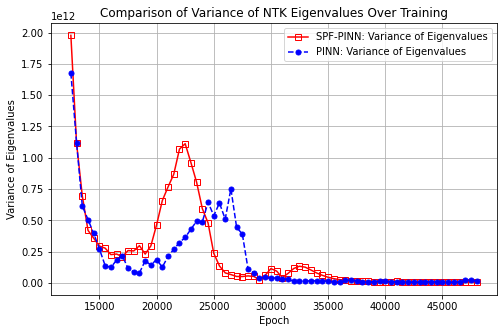

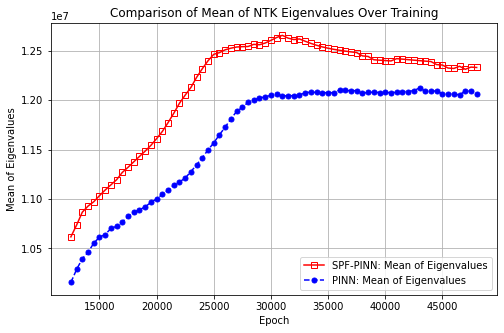

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
start_epoch = 12500
step_interval = 4  # 每隔 4 轮计算一次
interval = 500  # 训练步长，影响 epoch 计算

# 转换为 NumPy 数组
eigenvalues_k_history1 = np.array(eigenvalues_k_history1)
eigenvalues_k_history = np.array(eigenvalues_k_history)

# 计算数量信息eigenvalues_k_history
num_snapshots1 = len(eigenvalues_k_history1)
num_snapshots2 = len(eigenvalues_k_history)
assert num_snapshots1 == num_snapshots2, "两组特征值历史长度不匹配"

# 存储计算结果
var_over_time1, mean_over_time1, var_over_time2, mean_over_time2 = [], [], [], []
epochs = []

# 计算滑动窗口的方差和均值
for i in range(num_snapshots1 - step_interval):
    epoch = (i + 1) * interval
    if epoch >= start_epoch:
        # 计算第一组
        eigenvalues_segment1 = eigenvalues_k_history1[i : i + step_interval]
        eigenvar1 = np.var(eigenvalues_segment1, axis=0)
        eigenmean1 = np.mean(eigenvalues_segment1, axis=0)
        valid_indices1 = eigenmean1 >= 1e-3
        filtered_eigenmean1 = eigenmean1[valid_indices1]

        # 计算第二组
        eigenvalues_segment2 = eigenvalues_k_history[i : i + step_interval]
        eigenvar2 = np.var(eigenvalues_segment2, axis=0)
        eigenmean2 = np.mean(eigenvalues_segment2, axis=0)
        valid_indices2 = eigenmean2 >= 1e-3
        filtered_eigenmean2 = eigenmean2[valid_indices2]

        # 计算整体均值和方差
        var_over_time1.append(np.mean(eigenvar1))
        mean_over_time1.append(np.mean(filtered_eigenmean1) if len(filtered_eigenmean1) > 0 else 0)

        var_over_time2.append(np.mean(eigenvar2))
        mean_over_time2.append(np.mean(filtered_eigenmean2) if len(filtered_eigenmean2) > 0 else 0)

        epochs.append(epoch)

# **第一张图：方差随 Epoch 变化**
plt.figure(figsize=(8, 5))
plt.plot(epochs, var_over_time1, marker='s', linestyle='-', color='r',  markerfacecolor='none',label="SPF-PINN: Variance of Eigenvalues")
plt.plot(epochs, var_over_time2, marker='o', linestyle='--', color='b',markersize=5,label="PINN: Variance of Eigenvalues")
plt.xlabel("Epoch")
plt.ylabel("Variance of Eigenvalues")
plt.title("Comparison of Variance of NTK Eigenvalues Over Training")
plt.legend()
plt.grid(True)



# **第二张图：均值随 Epoch 变化**
plt.figure(figsize=(8, 5))
plt.plot(epochs, mean_over_time1, marker='s', linestyle='-', color='r',  markerfacecolor='none',label="SPF-PINN: Mean of Eigenvalues")
plt.plot(epochs, mean_over_time2, marker='o', linestyle='--', color='b', 
         markersize=5, label="PINN: Mean of Eigenvalues")
plt.xlabel("Epoch")
plt.ylabel("Mean of Eigenvalues")
plt.title("Comparison of Mean of NTK Eigenvalues Over Training")
plt.legend()
plt.grid(True)


